**<h2 style='color:red'>Титаник: мой проект с использованием EDA и разных методов машинного обучения</h2>**
*  1- Подготовка данных 
*  2- Визуализация данных 
*  3- Подготовка данных для машинного обучения
*  4- Поиск лучшего классификатора
<hr>

# Подготовка данных

In [1]:
import warnings
warnings.simplefilter("ignore")

#Импортируем библиотеки для анализа
import pandas as pd
import numpy as np

#Импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Подгрузим данные
train_df = pd.read_csv('../input/titanic/train.csv')
test_df = pd.read_csv('../input/titanic/test.csv')
sub = pd.read_csv('../input/titanic/gender_submission.csv')

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Проверим данные на пропущенные значения
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
#Cоздадим новые переменные

train_df['Name_length'] = train_df['Name'].apply(len)
test_df['Name_length'] = test_df['Name'].apply(len)
train_df['Has_Cabin'] = train_df["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test_df['Has_Cabin'] = test_df["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

In [5]:
#Почистим данные от NA и выбросим лишние столбцы
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(np.nan, "mean")

train_df['Age'] = imputer.fit_transform(np.array(train_df['Age']).reshape(891, 1)) 
train_df.Embarked.fillna(method='ffill', inplace=True) 
train_df.drop(['PassengerId', 'Name', 'Cabin'], axis=1, inplace=True) 

test_df['Age'] = imputer.fit_transform(np.array(test_df['Age']).reshape(418, 1))
test_df.Embarked.fillna(method='ffill', inplace=True)
test_df.Fare.fillna(method='ffill', inplace=True)
test_df.drop(['PassengerId', 'Name', 'Cabin'], axis=1, inplace=True)

# Визуализация данных

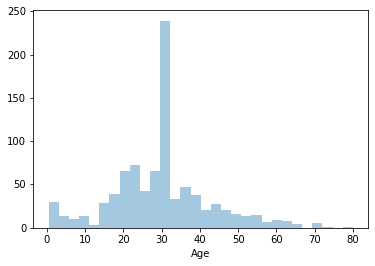

In [6]:
sns.distplot(train_df["Age"], kde = False )

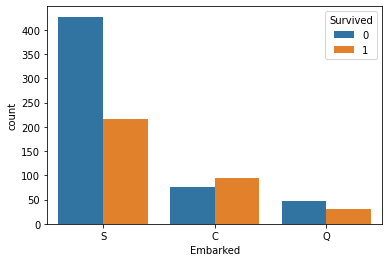

In [7]:
sns.countplot(x='Embarked', hue='Survived', data=train_df)

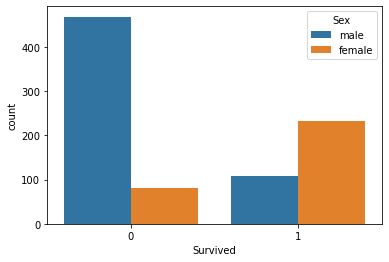

In [8]:
sns.countplot(x='Survived', hue='Sex', data=train_df)

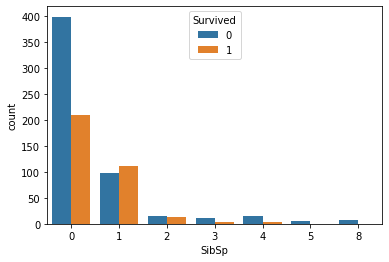

In [9]:
sns.countplot(x='SibSp', hue='Survived', data=train_df)

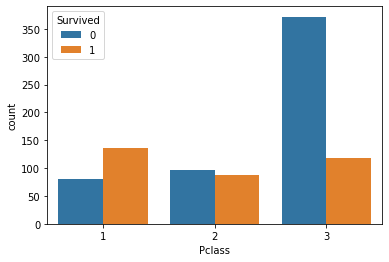

In [10]:
sns.countplot(x='Pclass', hue='Survived', data=train_df)

# Подготовка данных для машинного обучения

In [11]:
# Перекодируем категориальные данные 

objects_cols = train_df.select_dtypes("object").columns

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_df[objects_cols] = train_df[objects_cols].apply(le.fit_transform)
test_df[objects_cols] = test_df[objects_cols].apply(le.fit_transform)

train_df.head()



,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Name_length,Has_Cabin
0,0,3,1,22.0,1,0,523,7.2500,2,23,0
1,1,1,0,38.0,1,0,596,71.2833,0,51,1
2,1,3,0,26.0,0,0,669,7.9250,2,22,0
3,1,1,0,35.0,1,0,49,53.1000,2,44,1
4,0,3,1,35.0,0,0,472,8.0500,2,24,0


In [12]:
#Разобьем данные и промасштабируем данные
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
X = train_df.drop(['Survived'], 1).values
y = train_df['Survived'].values

scale = StandardScaler()
scale.fit(X)
X = scale.transform(X)

scale.fit(test_df)
test_df = scale.transform(test_df)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

# Найдем лучший классификатор 

In [13]:
# Переберем разные классификаторы и создадим из результатов словарь
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.model_selection import cross_val_score

cols = ["Classifier", "Accuracy"]
df = pd.DataFrame(columns=cols)

dicti = {}

classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression()]

for clf in classifiers:
    cv_results = cross_val_score(clf, X_train, y_train, scoring="roc_auc", cv=10)
    res = np.mean(cv_results)
    name =clf.__class__.__name__
    dicti[name] = res
                  
xg_cl = xgb.XGBClassifier(objective='binary:logistic', seed=0)
cv_results = cross_val_score(xg_cl, X_train, y_train, scoring="roc_auc", cv=10)
dicti['XGBClassifier'] = np.mean(cv_results)

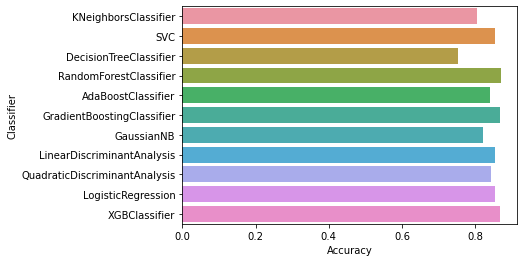

In [14]:
# Создадим датафрейм и визуализируем результатаы 
for clf in dicti:
    dfe = pd.DataFrame([[clf, dicti[clf]]], columns=cols)
    df = df.append(dfe)
    
sns.barplot(x='Accuracy', y='Classifier', data=df)